# Geolocation of Attacker IP Addresses

Using log data from a Cowrie honeypot stored in an SQLite database, we can plot the attackers on a map. 

In [9]:
import common
import pandas as pd
import folium
import matplotlib.pyplot as plt
import numpy as np

conn = common.connect_db('db.sqlite')
data = pd.read_sql_query("SELECT * from attacker_profiles", conn)

m = folium.Map(location=[50, -25], zoom_start=3)

for index, element in data.iterrows():
    src_ip = element['src_ip']
    lat = element['latitude']
    lon = element['longitude']
    country_name = element['country_name']
    subdivision_name = element['subdivision_name']
    city_name = element['city_name']
    radius = element['accuracy_radius']
    attack_count = element['attack_count']
    
    if element['asn'] is not None:
        asn = element['asn']
    else:
        asn = "No ASN"
    
    if element['subdivision_name'] is not None:
        subdivision_name = element['subdivision_name']
    else:
        subdivision_name = ""

    popup_tag = '<i>' +city_name+', '+subdivision_name+', '+ '</i><b>'+ country_name+'<br><br></b>Accuracy: '+str(radius)+'km <br>' + 'Attacks: ' + str(attack_count) +'<br><br>'+ str(asn) + '<b><br>' + str(src_ip) + '</b></i>'
    folium.Marker([lat, lon], popup=popup_tag).add_to(m)
m

## Attacks by IP Address

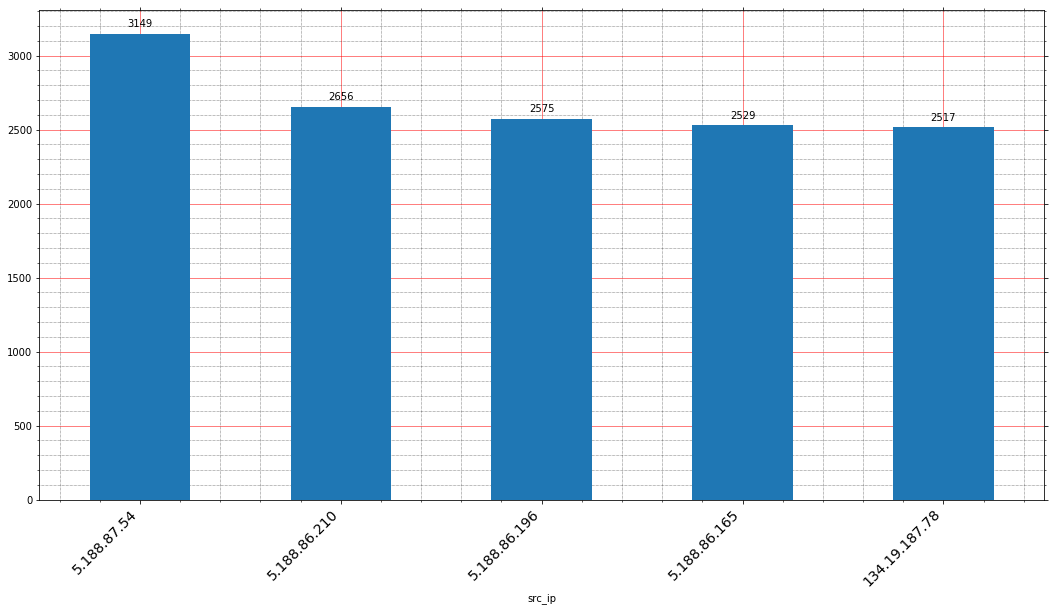

In [12]:
# Group data by country

data = pd.read_sql_query("SELECT * from attacker_profiles", conn)

# Filter data
data = data[['src_ip','attack_count']]
data = data.where((pd.notnull(data)),None)
data = data[~data['attack_count'].isin(['NaN','nan',None,'0',''])]

# This fixes a strange glitch where attack_count was shown as float
data["attack_count"] = pd.to_numeric(data["attack_count"], downcast='integer')

data = data.sort_values(['attack_count'],ascending=False)

fig, ax = plt.subplots()

data[0:5].plot('src_ip','attack_count', legend = None, kind='bar', color = '#1f77b4', figsize=(18, 9), ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2),
    (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center',
    xytext=(0, 10), textcoords='offset points')
    # Turn on the minor TICKS, which are required for the minor GRID

ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
        top=True, # turn off top ticks
        left=True, # turn off left ticks
        right=True, # turn off right ticks
        bottom=True) # turn off bottom ticks

## Attacks by Country

Here is some markdown, blah blah blah

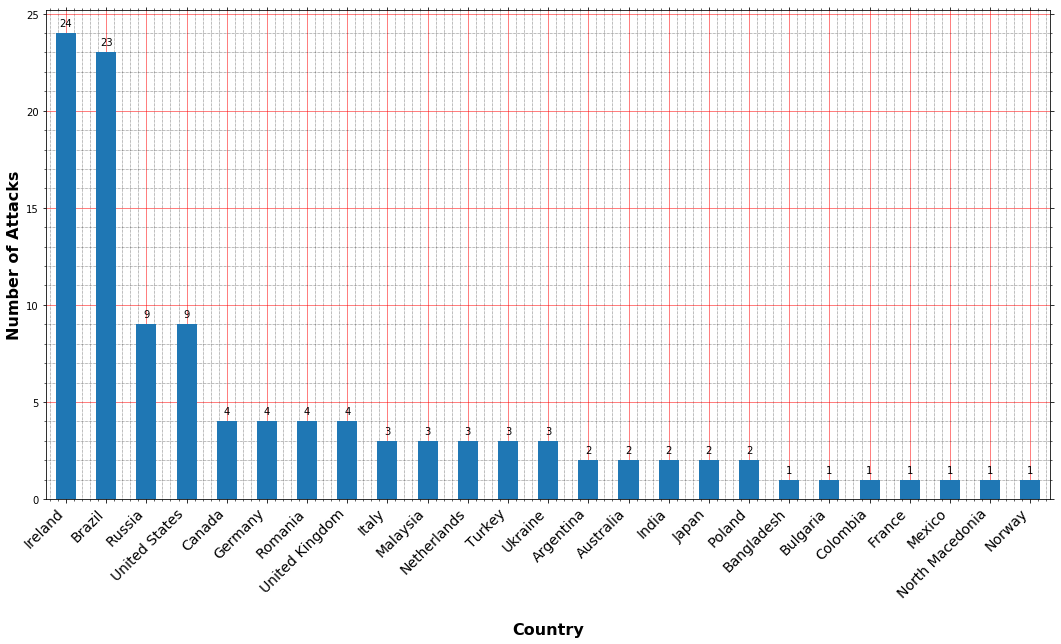

In [10]:
#@hidden_cell

# Group data by country
data = pd.read_sql_query("SELECT * from attacker_profiles", conn)
country = data.groupby(['country_name']).size().to_frame('attack_count').reset_index().sort_values(by=['attack_count','country_name'], ascending=[False, True])

# Use the rank function to sort countries by the number of attacks
country['Rank'] = country['attack_count'].rank(method='dense', ascending=False).astype(int)

fig, ax = plt.subplots()
country[0:25].plot('country_name','attack_count', legend = None, kind='bar', color = '#1f77b4', figsize=(18, 9), ax=ax)

ax.set_xlabel('\nCountry', fontweight="bold", size=16)
ax.set_ylabel('Number of Attacks', fontweight="bold", size=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2),
    (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center',
    xytext=(0, 10), textcoords='offset points')
    # Turn on the minor TICKS, which are required for the minor GRID

ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
        top=True, # turn off top ticks
        left=True, # turn off left ticks
        right=True, # turn off right ticks
        bottom=True) # turn off bottom ticks


## Attacks by City of Origin

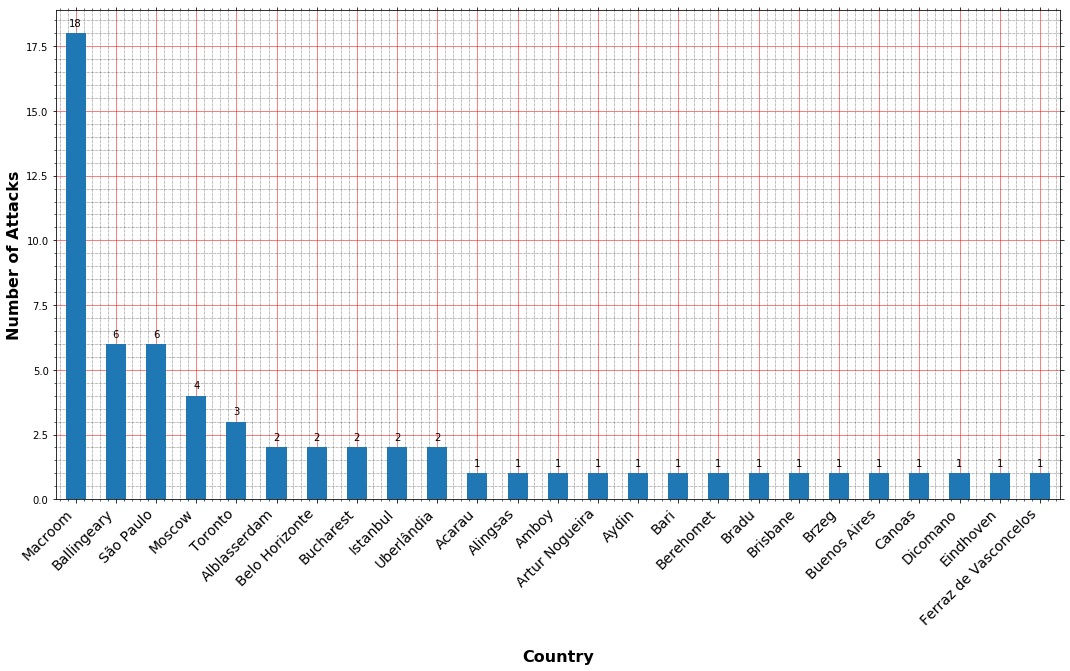

In [11]:
# Group data by country
country = data.groupby(['city_name']).size().to_frame('attack_count').reset_index().sort_values(by=['attack_count','city_name'], ascending=[False, True])

# Use the rank function to sort countries by the number of attacks
country['Rank'] = country['attack_count'].rank(method='dense', ascending=False).astype(int)

fig, ax = plt.subplots()
country[0:25].plot('city_name','attack_count', legend = None, kind='bar', color = '#1f77b4', figsize=(18, 9), ax=ax)


ax.set_xlabel('\nCountry', fontweight="bold", size=16)
ax.set_ylabel('Number of Attacks', fontweight="bold", size=16)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha="right")

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2),
    (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center',
    xytext=(0, 10), textcoords='offset points')
    # Turn on the minor TICKS, which are required for the minor GRID

ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# Turn off the display of all ticks.
ax.tick_params(which='both', # Options for both major and minor ticks
        top=True, # turn off top ticks
        left=True, # turn off left ticks
        right=True, # turn off right ticks
        bottom=True) # turn off bottom ticks
